In [100]:
import numpy as np
import pandas as pd
import glob
import random
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats, sigma_clip, SigmaClip
from astropy.visualization import SqrtStretch, ZScaleInterval, SinhStretch, LinearStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import scipy.stats as stats

from photutils.centroids import centroid_com, centroid_1dg, centroid_2dg
from photutils.aperture import aperture_photometry 
from photutils.aperture import CircularAperture
from photutils.aperture import SkyCircularAperture
from photutils.background import Background2D
from photutils.psf import BasicPSFPhotometry, IntegratedGaussianPRF, IterativelySubtractedPSFPhotometry, DAOGroup
from photutils.detection import DAOStarFinder

In [152]:
def median_frames(folder, filenames):

    cube = np.zeros((len(filenames), 1024, 1056))

    for i, f in enumerate(filenames):

        hdul = fits.open(f'{folder}/{f}.fits')
        cube[i, :, :] = hdul[0].data
        hdul.close()

    cube_med = np.median(cube, axis=0)

    return cube_med

def find_zero_point(m, counts):
    """ m = -2.5 log_10(counts) + ZP --> return ZP """
    return m + 2.5*np.log10(counts)

def app_to_abs_mag(m, D):
    return m - 5*np.log10(D) + 5

def app_mag_from_counts(C, C0):
    return -2.5*np.log10(C) + C0


In [102]:
## Locate HR data (combo of Sagnick's & my calibrations, Jules' and Doug's data)

folder = '/Users/isabelkain/Desktop/HR_data'
filelist = glob.glob(f'{folder}/*.fits')

## Generate list of filenames

fnames = np.array([])
fpaths = np.array([])

for f in filelist:
    txt = f.split('/')[-1].split('.')[0]  # reduce full path to just file name (w/out extension)
    fnames = np.append(fnames, txt)
    fpaths = np.append(fpaths, f[:-11])

## List of filetypes (e.g. bias, flat, science, etc)

ftypes = np.array([])

for f in filelist:

    hdul = fits.open(f)
    tag = hdul[0].header['OBJECT']
    hdul.close()

    ftypes = np.append(ftypes, tag)

## Zip filenames and types into pandas DF

filedict = pd.DataFrame(np.array([fpaths, fnames, ftypes]).T, columns=['Path', 'Filename', 'Target'])
filedict.sort_values(by='Filename', inplace=True, ignore_index=True)
filedict

,Path,Filename,Target
0,/Users/isabelkain/Desktop/HR_data,d2035,bias
1,/Users/isabelkain/Desktop/HR_data,d2036,bias
2,/Users/isabelkain/Desktop/HR_data,d2037,bias
3,/Users/isabelkain/Desktop/HR_data,d2038,bias
4,/Users/isabelkain/Desktop/HR_data,d2039,darks
5,/Users/isabelkain/Desktop/HR_data,d2040,darks
6,/Users/isabelkain/Desktop/HR_data,d2041,darks
7,/Users/isabelkain/Desktop/HR_data,d2042,darks
8,/Users/isabelkain/Desktop/HR_data,d2043,darks
9,/Users/isabelkain/Desktop/HR_data,d2044,domeflats_B


In [103]:
## Jules and Doug marked some files as either tests or bad data

badlist = np.array(['d2112', 'd2117', 'd2122', 'd2123', 'd2128'])
filedict = filedict[~filedict['Filename'].isin(badlist)].reset_index()

## bad and test frames have now been removed

# Calibration

## Bias

Text(0.5, 1.0, 'Bias')

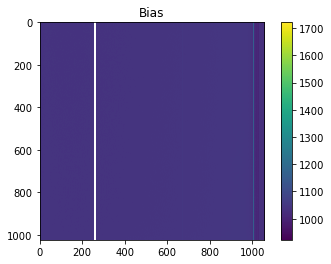

In [104]:
## Read in, median bias frames

c = (filedict['Target']=='bias')
fnames = filedict[c]['Filename'].array
path = filedict[c]['Path'].array[0]

bias = median_frames(path, fnames)

## Mask bad column
colmask = bias > 10000.

## Plot bias
plt.imshow(np.ma.array(data=bias, mask=colmask))
plt.colorbar()
plt.title('Bias')


## Darks

Text(0.5, 1.0, 'Darks (pre-bias subtraction)')

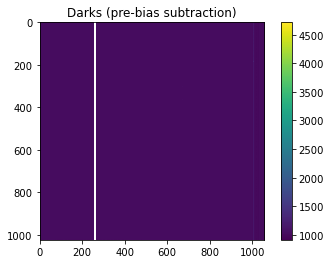

In [105]:
## Read in, median dark frames

c = (filedict['Target']=='darks')
fnames = filedict[c]['Filename'].array
path = filedict[c]['Path'].array[0]

darks_med = median_frames(path, fnames)

## Plot bias
plt.imshow(np.ma.array(data=darks_med, mask=colmask))
plt.colorbar()
plt.title('Darks (pre-bias subtraction)')


## Dome flats

In [106]:
## Read in, median dome flats -- V band

c = (filedict['Target']=='domeflats_V')
fnames = filedict[c]['Filename'].array
path = filedict[c]['Path'].array[0]

domeflats_med_V = median_frames(path, fnames)


## Read in, median dome flats -- V band

c = (filedict['Target']=='domeflats_B')
fnames = filedict[c]['Filename'].array
path = filedict[c]['Path'].array[0]

domeflats_med_B = median_frames(path, fnames)


Text(0.5, 1.0, 'B-band dome flats')

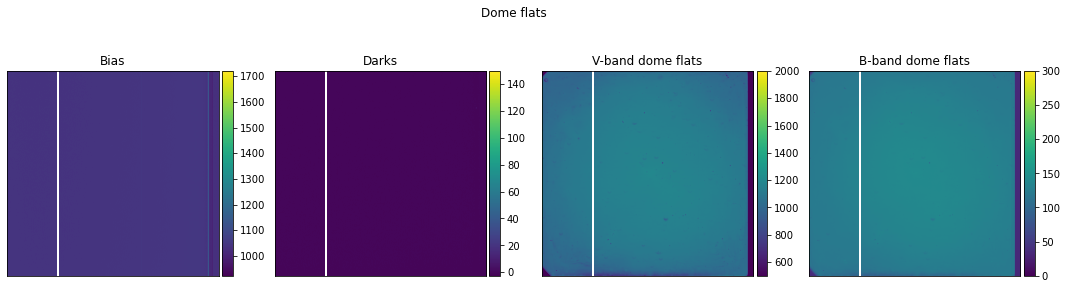

In [107]:
## Finalize calibration frames

# bias = bias
dark = (darks_med - bias) / 20.
flat_V = (domeflats_med_V - dark) / 10.
flat_B = (domeflats_med_B - dark) / 30.


## Plot calibration frames

fig, ax = plt.subplots(1,4,figsize=(15,5))
plt.tight_layout()

im1 = ax[0].imshow(np.ma.array(data=bias, mask=colmask))
im2 = ax[1].imshow(np.ma.array(data=dark, mask=colmask))
im3 = ax[2].imshow(np.ma.array(data=flat_V, mask=colmask), vmin=500, vmax=2000)
im4 = ax[3].imshow(np.ma.array(data=flat_B, mask=colmask), vmin=0, vmax=300)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')

divider = make_axes_locatable(ax[1])
cax2 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')

divider = make_axes_locatable(ax[2])
cax3 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax3, orientation='vertical')

divider = make_axes_locatable(ax[3])
cax4 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax4, orientation='vertical')

ax[0].tick_params(left=False, bottom=False) 
ax[1].tick_params(left=False, bottom=False) 
ax[2].tick_params(left=False, bottom=False) 
ax[3].tick_params(left=False, bottom=False) 
ax[0].set(yticklabels=[], xticklabels=[]) 
ax[1].set(yticklabels=[], xticklabels=[]) 
ax[2].set(yticklabels=[], xticklabels=[]) 
ax[3].set(yticklabels=[], xticklabels=[]) 

fig.suptitle('Dome flats')
ax[0].set_title('Bias')
ax[1].set_title('Darks')
ax[2].set_title('V-band dome flats')
ax[3].set_title('B-band dome flats')


# Landolt

## V-band

Text(0.5, 1.0, 'Calibrated Landolt field\nV-band')

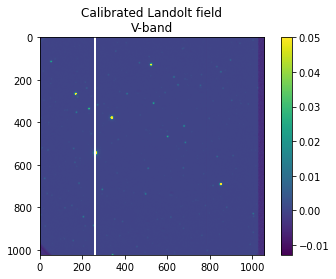

In [108]:
## Read in, median Landolt frames

c = (filedict['Target']=='landolt_V')
fnames = filedict[c]['Filename'].array
path = filedict[c]['Path'].array[0]

landolt_med_V = median_frames(path, fnames)


## Calibrate

landolt_V = (((landolt_med_V - bias) / 20.) - dark) / flat_V

## Estimate and remove background

# I explored a couple of solutions, which did not work:
# - Gaussian blurring of image with the stars masked out: 
#     under-corrects the stars themselves
# - Masking stars and inpainting masked regions to get a
#     fully-interpolated background estimation; took
#     super fucking long and made a mess of things
# - Averaging a sigma-clipped frame: fine >

__, median_lV, __ = sigma_clipped_stats(landolt_V, sigma=1) ## most stringent clip lowers std, but doesn't change mean & median much

landolt_V = landolt_V - median_lV


## Plot
plt.imshow(np.ma.array(data=landolt_V, mask=colmask), vmax=0.05)
plt.colorbar()
plt.title('Calibrated Landolt field\nV-band')


<SkyCoord (ICRS): (ra, dec) in deg
    [(294.42315036, 0.44748783), (294.43036369, 0.43015445),
     (294.36932634, 0.4174358 )]>


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


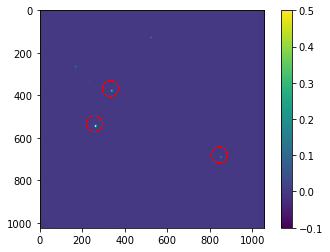

In [109]:
## Identify Landolt stars by known sky coordinates

# 3 stars in Landolt field (from SIMBAD):
coords = [
    "19:37:41.5560872158 +00:26:50.956187843", 
    "19:37:43.2872858025 +00:25:48.556032054",
    "19:37:28.6383220050 +00:25:02.768886460"
]

positions = SkyCoord(coords,
                     frame='icrs',
                     equinox='J2000',
                     unit=(u.hourangle, u.deg))
apertures_sky = SkyCircularAperture(positions, 14. * u.arcsec)

print(positions)
"""
'For the latter, we relied
upon standard aperture photometry using an aperture diameter
of 14′′ since this was the same size favored by Landolt (1992,
2009) in measuring the flux of his standard stars.'

>> https://iopscience.iop.org/article/10.1088/0004-6256/141/4/115/pdf
"""

## Grab WCS from last telescope image

c = (filedict['Target'] == 'landolt_V')
path = filedict[c]['Path'].array[0]
fname = filedict[c]['Filename'].array[-1]

hdu = fits.open(f'{path}/{fname}.fits')[0]

wcs = WCS(hdu.header)
frame = hdu.header['RADESYSS'].lower()
ra = hdu.header['RA']
dec = hdu.header['DEC']

## Convert SkyCircularAperture to CircularAperture using WCS
apertures_px = apertures_sky.to_pixel(wcs)

## Plot
plt.imshow(landolt_V, vmax=0.5)
plt.colorbar()
apertures_px.plot(color='red')
plt.show()

In [110]:
## Save Landolt image with WCS info

position = SkyCoord(f'{ra} {dec}', frame=frame, unit=(u.hourangle, u.deg))
cutout = Cutout2D(landolt_V, position=position, size=np.shape(landolt_V), wcs=wcs)

hdu = fits.PrimaryHDU(cutout.data)
hdu.header.update(cutout.wcs.to_header())

hdul = fits.HDUList([hdu])
hdul.writeto('landolt_V_calibrated.fits', overwrite=True)


In [111]:
## Isolate one Landolt star

# Star 1: TYC 479-1283-1

radius = apertures_px.r
xpos = apertures_px.positions[0, 1]
ypos = apertures_px.positions[0, 0]

x, y = np.ogrid[0:np.shape(bias)[0], 0:np.shape(bias)[1]]

starmask_1 = np.sqrt( (x-xpos)**2 + (y-ypos)**2 ) <= radius
isolated_star_1 = landolt_V*starmask_1

## Find centroid in window around star, place new aperture at centroid

x1dg, y1dg = centroid_1dg(isolated_star_1)  # x, y = is the correct order
new_aperture_1 = CircularAperture([x1dg, y1dg], apertures_px.r) # [x, y] is the correct order


## Repeat for the other two Landolt stars

# Star 2: BD+00 4260

xpos = apertures_px.positions[1, 1]
ypos = apertures_px.positions[1, 0]

starmask_2 = np.sqrt( (x-xpos)**2 + (y-ypos)**2 ) <= radius
isolated_star_2 = landolt_V * starmask_2

x1dg, y1dg = centroid_1dg(isolated_star_2) 
new_aperture_2 = CircularAperture([x1dg, y1dg], apertures_px.r)


# Star 3: GSC 00478-01393

xpos = apertures_px.positions[2, 1]
ypos = apertures_px.positions[2, 0]

print(apertures_px.positions[2], xpos, ypos)

starmask_3 = np.sqrt( (x-xpos)**2 + (y-ypos)**2 ) <= radius
isolated_star_3 = landolt_V * starmask_3

x1dg, y1dg = centroid_1dg(isolated_star_3) 
new_aperture_3 = CircularAperture([x1dg, y1dg], apertures_px.r)


[843.43698685 678.60363993] 678.6036399279841 843.4369868506976


(<matplotlib.patches.Circle at 0x7f9f00303940>,)

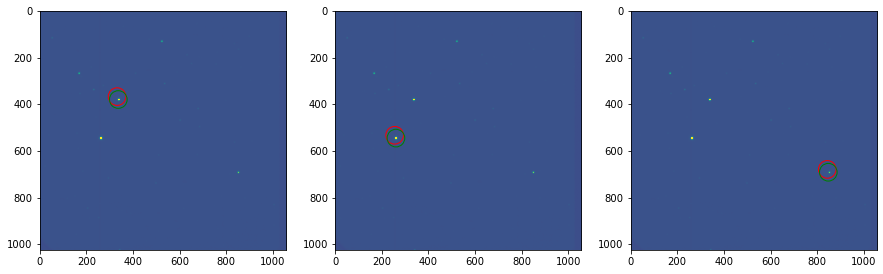

In [112]:
## Plot three new apertures

fig, ax = plt.subplots(1,3,figsize=(15,6))

ax[0].imshow(landolt_V, vmax=0.3)
ax[1].imshow(landolt_V, vmax=0.3)
ax[2].imshow(landolt_V, vmax=0.3)

apertures_px[0].plot(axes=ax[0], color='r')
apertures_px[1].plot(axes=ax[1], color='r')
apertures_px[2].plot(axes=ax[2], color='r')

new_aperture_1.plot(axes=ax[0], color='g')
new_aperture_2.plot(axes=ax[1], color='g')
new_aperture_3.plot(axes=ax[2], color='g')

In [113]:
## Do aperture photometry on each new aperture

apsum_1 = aperture_photometry(landolt_V, new_aperture_1)[0]['aperture_sum']
apsum_2 = aperture_photometry(landolt_V, new_aperture_2)[0]['aperture_sum']
apsum_3 = aperture_photometry(landolt_V, new_aperture_3)[0]['aperture_sum']

print(apsum_1, apsum_2, apsum_3)

25.06018458453288 61.01831490446929 11.051363515652051


In [146]:
## Tabulate Landolt star data

id_ = ['TYC 479-1283-1', 'BD+00 4260', 'GSC 00478-01393']
plax = [0.0006769, 0.0008591, 0.0010204]
vmag = [11.419, 10.382, 12.387]
bmag = [13.129, 12.341, 12.783]
bright = [apsum_1, apsum_2, apsum_3]

## Load into table

startable = pd.DataFrame(data=np.array([id_,  plax, bright, np.zeros(3), vmag, bmag]).T, 
                         columns=['ID', 'Parallax (asec)', 'Counts (V)', 'Counts (B)', 'App mag (V)', 'App mag (B)'])

## Add absolute magnitudes
# m, D

# float(1./startable.loc[0, 'Parallax (asec)'])
MV_1 = app_to_abs_mag(float(startable.loc[0, 'App mag (V)']), 1./float(startable.loc[0, 'Parallax (asec)']))
MV_2 = app_to_abs_mag(float(startable.loc[1, 'App mag (V)']), 1./float(startable.loc[1, 'Parallax (asec)']))
MV_3 = app_to_abs_mag(float(startable.loc[2, 'App mag (V)']), 1./float(startable.loc[2, 'Parallax (asec)']))
MB_1 = app_to_abs_mag(float(startable.loc[0, 'App mag (B)']), 1./float(startable.loc[0, 'Parallax (asec)']))
MB_2 = app_to_abs_mag(float(startable.loc[1, 'App mag (B)']), 1./float(startable.loc[1, 'Parallax (asec)']))
MB_3 = app_to_abs_mag(float(startable.loc[2, 'App mag (B)']), 1./float(startable.loc[2, 'Parallax (asec)']))

startable['Abs mag (V)'] = np.array([MV_1, MV_2, MV_3])
startable['Abs mag (B)'] = np.array([MB_1, MB_2, MB_3])

startable

,ID,Parallax (asec),Counts (V),Counts (B),App mag (V),App mag (B),Abs mag (V),Abs mag (B)
0,TYC 479-1283-1,0.0006769,36.84108754940932,0.0,11.419,13.129,0.571623,2.281623
1,BD+00 4260,0.0008591,67.54340109164387,0.0,10.382,12.341,0.052219,2.011219
2,GSC 00478-01393,0.0010204,49.646996481497325,0.0,12.387,12.783,2.430852,2.826852


## B-band

Text(0.5, 1.0, 'Calibrated Landolt field\nB-band')

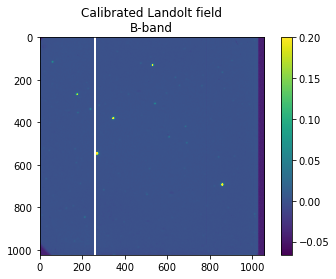

In [158]:
## Read in, median dark frames

c = (filedict['Target']=='landolt b')
fnames = filedict[c]['Filename'].array
path = filedict[c]['Path'].array[0]

landolt_med_B = median_frames(path, fnames)


## Calibrate

landolt_B = (((landolt_med_B - bias) / 20.) - dark) / flat_B

__, median_lB, __ = sigma_clipped_stats(landolt_B, sigma=1)

landolt_B = landolt_B - median_lB

## Plot bias
plt.imshow(np.ma.array(data=landolt_B, mask=colmask), vmax=0.2)
plt.colorbar()
plt.title('Calibrated Landolt field\nB-band')


<SkyCoord (ICRS): (ra, dec) in deg
    [(294.42315036, 0.44748783), (294.43036369, 0.43015445),
     (294.36932634, 0.4174358 )]>


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


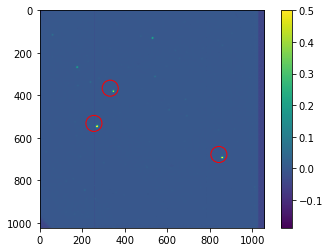

In [159]:
## Place apertures

# 3 stars in Landolt field (from SIMBAD):
coords = [
    "19:37:41.5560872158 +00:26:50.956187843", 
    "19:37:43.2872858025 +00:25:48.556032054",
    "19:37:28.6383220050 +00:25:02.768886460"
]

positions = SkyCoord(coords,
                     frame='icrs',
                     equinox='J2000',
                     unit=(u.hourangle, u.deg))
apertures_sky = SkyCircularAperture(positions, 14. * u.arcsec)

print(positions)


## Grab WCS from last telescope image

c = (filedict['Target'] == 'landolt b')
path = filedict[c]['Path'].array[0]
fname = filedict[c]['Filename'].array[-1]

hdu = fits.open(f'{path}/{fname}.fits')[0]

wcs = WCS(hdu.header)
frame = hdu.header['RADESYSS'].lower()
ra = hdu.header['RA']
dec = hdu.header['DEC']

## Convert SkyCircularAperture to CircularAperture using WCS
apertures_px = apertures_sky.to_pixel(wcs)

## Plot
plt.imshow(landolt_B, vmax=0.5)
plt.colorbar()
apertures_px.plot(color='red')
plt.show()

In [160]:
## Save Landolt image with WCS info

position = SkyCoord(f'{ra} {dec}', frame=frame, unit=(u.hourangle, u.deg))
cutout = Cutout2D(landolt_B, position=position, size=np.shape(landolt_B), wcs=wcs)

hdu = fits.PrimaryHDU(cutout.data)
hdu.header.update(cutout.wcs.to_header())

hdul = fits.HDUList([hdu])
hdul.writeto('landolt_B_calibrated.fits', overwrite=True)


In [161]:
# Star 1: TYC 479-1283-1

radius = apertures_px.r
xpos = apertures_px.positions[0, 1]
ypos = apertures_px.positions[0, 0]

x, y = np.ogrid[0:np.shape(bias)[0], 0:np.shape(bias)[1]]

starmask_1 = np.sqrt( (x-xpos)**2 + (y-ypos)**2 ) <= radius
isolated_star_1 = landolt_B*starmask_1

## Find centroid in window around star, place new aperture at centroid

x1dg, y1dg = centroid_1dg(isolated_star_1)  # x, y = is the correct order
new_aperture_1 = CircularAperture([x1dg, y1dg], apertures_px.r) # [x, y] is the correct order


## Repeat for the other two Landolt stars

# Star 2: BD+00 4260

xpos = apertures_px.positions[1, 1]
ypos = apertures_px.positions[1, 0]

starmask_2 = np.sqrt( (x-xpos)**2 + (y-ypos)**2 ) <= radius
isolated_star_2 = landolt_B * starmask_2

x1dg, y1dg = centroid_1dg(isolated_star_2) 
new_aperture_2 = CircularAperture([x1dg, y1dg], apertures_px.r)


# Star 3: GSC 00478-01393

xpos = apertures_px.positions[2, 1]
ypos = apertures_px.positions[2, 0]

print(apertures_px.positions[2], xpos, ypos)

starmask_3 = np.sqrt( (x-xpos)**2 + (y-ypos)**2 ) <= radius
isolated_star_3 = landolt_B * starmask_3

x1dg, y1dg = centroid_1dg(isolated_star_3) 
new_aperture_3 = CircularAperture([x1dg, y1dg], apertures_px.r)

[843.44818249 678.31220893] 678.3122089310989 843.4481824857837


(<matplotlib.patches.Circle at 0x7f9f01c85b80>,)

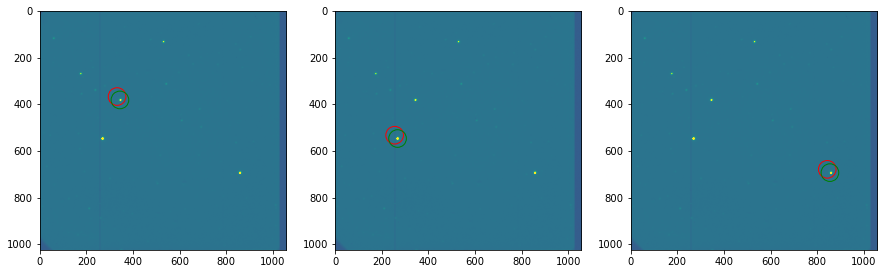

In [162]:
## Plot three new apertures

fig, ax = plt.subplots(1,3,figsize=(15,6))

ax[0].imshow(landolt_B, vmax=0.3)
ax[1].imshow(landolt_B, vmax=0.3)
ax[2].imshow(landolt_B, vmax=0.3)

apertures_px[0].plot(axes=ax[0], color='r')
apertures_px[1].plot(axes=ax[1], color='r')
apertures_px[2].plot(axes=ax[2], color='r')

new_aperture_1.plot(axes=ax[0], color='g')
new_aperture_2.plot(axes=ax[1], color='g')
new_aperture_3.plot(axes=ax[2], color='g')

In [163]:
## Do aperture photometry on each new aperture

apsum_1 = aperture_photometry(landolt_B, new_aperture_1)[0]['aperture_sum']
apsum_2 = aperture_photometry(landolt_B, new_aperture_2)[0]['aperture_sum']
apsum_3 = aperture_photometry(landolt_B, new_aperture_3)[0]['aperture_sum']

print(apsum_1, apsum_2, apsum_3)

36.84108754940932 67.54340109164387 49.646996481497325


In [164]:
## Save B brightnesses 

startable['Counts (B)'] = np.array([apsum_1, apsum_2, apsum_3])
startable

,ID,Parallax (asec),Counts (V),Counts (B),App mag (V),App mag (B),Abs mag (V),Abs mag (B)
0,TYC 479-1283-1,0.0006769,36.84108754940932,36.841088,11.419,13.129,0.571623,2.281623
1,BD+00 4260,0.0008591,67.54340109164387,67.543401,10.382,12.341,0.052219,2.011219
2,GSC 00478-01393,0.0010204,49.646996481497325,49.646996,12.387,12.783,2.430852,2.826852


# Target -- NGC 6819

In [122]:
ap_radius_px = apertures_px.r ## already calibrated: 14" in pixels

## V-band

Text(0.5, 1.0, 'Calibrated target field\nV-band')

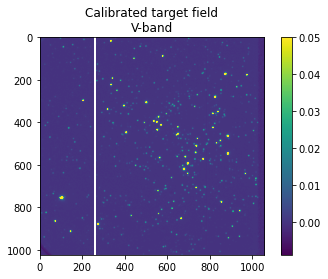

In [123]:
## Read in, median target frames

c = (filedict['Target']=='ngc6819_V')
fnames = filedict[c]['Filename'].array
path = filedict[c]['Path'].array[0]

ngc6819_med_V = median_frames(path, fnames)


## Calibrate

ngc6819_V = (((ngc6819_med_V - bias) / 20.) - dark) / flat_V

__, median_tV, __ = sigma_clipped_stats(ngc6819_V, sigma=1) 
ngc6819_V = ngc6819_V - median_tV


## Plot
plt.imshow(np.ma.array(data=ngc6819_V, mask=colmask), vmax=0.05)
plt.colorbar()
plt.title('Calibrated target field\nV-band')


In [124]:
# Mask out bad column, side column, left-hand corners
mask = np.copy(colmask)
mask[:, 1020:] = True
mask[1000:, :24] = True
mask[:24, :24] = True

425


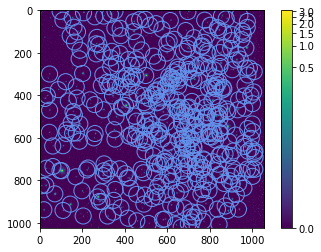

In [185]:
## Source-finding

# Source location
daofind_V = DAOStarFinder(fwhm=3.0, threshold=0.01)
sources_V = daofind_V(ngc6819_V, mask=mask)

print(len(sources_V))

for col in sources_V.colnames:
    sources_V[col].info.format = '%.8g'  # for consistent table output
    
# Place apertures over sources
positions = np.transpose((sources_V['xcentroid'], sources_V['ycentroid']))
apertures_V = CircularAperture(positions, r=ap_radius_px)


# Plot
norm = ImageNormalize(interval=ZScaleInterval(contrast=0.9), stretch=LogStretch(), vmin=0) 

plt.imshow(ngc6819_V, norm=norm, interpolation='nearest')
plt.colorbar()

apertures_V.plot(color='cornflowerblue');

In [186]:
## Do PSF photometry on star field in V

photometry_obj_V = IterativelySubtractedPSFPhotometry(finder=daofind_V, 
                                                      group_maker = DAOGroup(2.),
                                                      psf_model=IntegratedGaussianPRF(), 
                                                      bkg_estimator=None, 
                                                      aperture_radius=ap_radius_px, 
                                                      fitshape=13)

photV = photometry_obj_V.do_photometry(ngc6819_V, init_guesses=None)




In [187]:
## Convert results to DF, drop uncertain stars

photometry_V = photV.to_pandas()
photometry_V.dropna(inplace=True, axis='index')
photometry_V.drop_duplicates(subset=['group_id'], keep='first', inplace=True)
photometry_V = photometry_V[(photometry_V['x_0_unc']<=0.5) & (photometry_V['y_0_unc']<=0.5)]

photometry_V.reset_index(drop=False, inplace=True)

print(len(photV), len(photometry_V))

photometry_V

435 424


,index,x_0,x_fit,y_0,y_fit,flux_0,flux_fit,id,group_id,flux_unc,x_0_unc,y_0_unc,iter_detected
0,0,353.998862,354.002549,3.078525,3.089351,4.964550,0.148248,1,1,0.005110,0.050809,0.050795,1
1,1,95.730992,95.741025,3.930636,3.948547,0.848359,0.546106,2,2,0.017664,0.047656,0.047676,1
2,2,697.340686,697.414285,5.316702,5.322290,1.245400,0.567197,3,3,0.017832,0.046320,0.046292,1
3,3,205.796136,205.794226,11.100063,11.112421,0.546676,0.410456,4,4,0.012782,0.045888,0.045893,1
4,4,332.400208,332.456583,18.107191,18.134133,5.161071,2.524991,5,5,0.077771,0.045365,0.045389,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,421,717.010402,717.034502,996.477591,996.526397,1.534331,0.242695,422,422,0.003895,0.044687,0.044741,1
420,422,511.910647,511.922377,1003.032652,1003.049853,-0.053184,0.128392,423,423,0.008572,0.040944,0.040983,1
421,423,699.511542,699.499321,1004.505431,1004.533813,1.351779,0.308177,424,424,0.005886,0.040665,0.040699,1
422,424,844.231515,844.235177,1006.782378,1006.788541,-0.092418,0.213173,425,425,0.010629,0.041809,0.041865,1


In [188]:
## Save, look at fluxes (counts)

V_fluxes = photometry_V['flux_fit']


## B-band

0.00048465615809163844 3.312518972008183e-05 0.01845058698032968


Text(0.5, 1.0, 'Calibrated target field\nB-band')

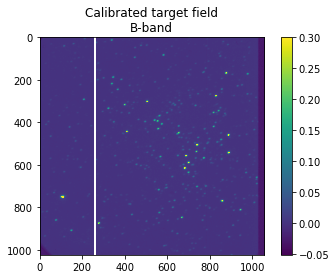

In [189]:
## Read in, median target frames

c = (filedict['Target']=='ngc6819_B')
fnames = filedict[c]['Filename'].array
path = filedict[c]['Path'].array[0]

ngc6819_med_B = median_frames(path, fnames)


## Calibrate

ngc6819_B = (((ngc6819_med_B - bias) / 20.) - dark) / flat_B

__, median_tB, __ = sigma_clipped_stats(ngc6819_B, sigma=1) 
ngc6819_B = ngc6819_B - median_tB

print( np.mean(ngc6819_B), np.median(ngc6819_B), np.std(ngc6819_B) )


## Plot
plt.imshow(np.ma.array(data=ngc6819_B, mask=colmask), vmax=0.3)
plt.colorbar()
plt.title('Calibrated target field\nB-band')


549


<ipython-input-190-3cfd9ccf2288>:23: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(ngc6819_B, norm=norm, interpolation='nearest', vmin=0)


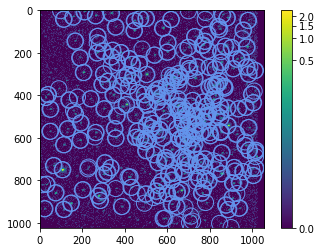

In [190]:
## Source-finding

daofind_B = DAOStarFinder(fwhm=3.0, threshold=0.02)
sources_B = daofind_B(ngc6819_B, mask=mask)

print(len(sources_B))

for col in sources_B.colnames:
    sources_B[col].info.format = '%.8g'  # for consistent table output
    
# Place apertures over sources
positions_B = np.transpose((sources_B['xcentroid'], sources_B['ycentroid']))
apertures_B = CircularAperture(positions_B, r=ap_radius_px)


# Place apertures over sources (pre-found in V-band)
apertures_B = CircularAperture(positions_B, r=ap_radius_px)


# Plot
norm = ImageNormalize(interval=ZScaleInterval(contrast=0.9), stretch=LogStretch()) 

plt.imshow(ngc6819_B, norm=norm, interpolation='nearest', vmin=0)
plt.colorbar()

apertures_B.plot(color='cornflowerblue');

In [191]:
## Do PSF photometry on star field in V

photometry_obj_B = IterativelySubtractedPSFPhotometry(finder=daofind_B, 
                                                      group_maker = DAOGroup(2.),
                                                      psf_model=IntegratedGaussianPRF(), 
                                                      bkg_estimator=None, 
                                                      aperture_radius=ap_radius_px, 
                                                      fitshape=13)

photB = photometry_obj_B.do_photometry(ngc6819_B, init_guesses=None)


In [192]:
## Change to pandas, clean

photometry_B = photB.to_pandas()
photometry_B.drop_duplicates(subset=['group_id'], keep='first', inplace=True)

photometry_B.reset_index(drop=False, inplace=True)

## can't drop NaN values since all positional uncertainties are NaN for some reason
photometry_B

,index,x_0,x_fit,y_0,y_fit,flux_0,flux_fit,id,group_id,iter_detected,flux_unc,x_0_unc,y_0_unc
0,0,97.784980,97.906036,0.877880,0.834139,0.269753,0.633116,1,1,1,NaN,NaN,NaN
1,1,699.715128,699.801919,1.370174,1.343491,1.499843,0.857854,2,2,1,NaN,NaN,NaN
2,2,211.304824,208.600743,6.056025,6.794232,1.609038,0.756879,3,3,1,NaN,NaN,NaN
3,3,208.221554,206.334193,6.923341,7.646582,1.677625,0.293243,4,4,1,NaN,NaN,NaN
4,4,780.916334,780.963215,9.488012,9.513942,1.027069,0.161836,5,5,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,548,719.411113,719.768274,992.137808,992.188269,1.515867,0.412996,549,547,1,NaN,NaN,NaN
547,549,705.230560,702.541361,999.335982,1000.062180,0.520832,0.530782,550,548,1,NaN,NaN,NaN
548,550,846.774024,846.854915,1002.706772,1002.674975,-2.582279,0.362444,551,549,1,NaN,NaN,NaN
549,551,641.627228,642.083145,1004.213256,1004.192023,0.083492,0.525721,552,550,1,NaN,NaN,NaN


## Matching & calibration

In [193]:
## Match stars between V and B starfinding routine
## <5px positional difference in both X and Y between bands

b_indx = np.array([])
v_indx = np.array([])

for i in range(len(photometry_B)):
    
    checkx = np.abs(photometry_B.loc[i,'x_fit'] - photometry_V['x_fit']) < 5.
    checky = np.abs(photometry_B.loc[i,'y_fit'] - photometry_V['y_fit']) < 5.
    check = checkx & checky
        
    if (np.sum(check)>1) or (np.sum(check)==0):
        continue
        
    # Throw out diplicates (i don't care enough to check if one is better than the other)
    if np.where(check)[0][0] in v_indx:
        print(f'Duplicate: b={i}, v={np.where(check)[0][0]}')
        continue
    
    v_indx = np.append(v_indx, np.where(check)[0][0])
    b_indx = np.append(b_indx, int(i))
    

print('Same length?', len(v_indx)==len(b_indx), len(v_indx))
print( 'Original V length: ', len(photometry_V) )
print( 'Original B length: ', len(photometry_B) )


Duplicate: b=3, v=3
Duplicate: b=8, v=7
Duplicate: b=15, v=10
Duplicate: b=17, v=11
Duplicate: b=19, v=12
Duplicate: b=26, v=16
Duplicate: b=29, v=23
Duplicate: b=33, v=26
Duplicate: b=35, v=27
Duplicate: b=38, v=29
Duplicate: b=39, v=30
Duplicate: b=41, v=35
Duplicate: b=43, v=38
Duplicate: b=48, v=44
Duplicate: b=53, v=48
Duplicate: b=59, v=53
Duplicate: b=62, v=54
Duplicate: b=64, v=55
Duplicate: b=69, v=59
Duplicate: b=76, v=63
Duplicate: b=77, v=64
Duplicate: b=80, v=65
Duplicate: b=81, v=66
Duplicate: b=85, v=70
Duplicate: b=88, v=71
Duplicate: b=93, v=75
Duplicate: b=97, v=78
Duplicate: b=102, v=82
Duplicate: b=104, v=84
Duplicate: b=109, v=88
Duplicate: b=111, v=89
Duplicate: b=118, v=94
Duplicate: b=119, v=95
Duplicate: b=127, v=101
Duplicate: b=128, v=102
Duplicate: b=130, v=103
Duplicate: b=132, v=104
Duplicate: b=134, v=105
Duplicate: b=143, v=113
Duplicate: b=145, v=116
Duplicate: b=147, v=117
Duplicate: b=152, v=121
Duplicate: b=156, v=126
Duplicate: b=158, v=127
Duplicat

In [194]:
## Save final (xy) positions and fluxes into table

stars_V = photometry_V.loc[v_indx, ['x_fit', 'y_fit', 'flux_fit']]
stars_B = photometry_B.loc[b_indx, ['x_fit', 'y_fit', 'flux_fit']]

stars_V.reset_index(drop=True, inplace=True)
stars_B.reset_index(drop=True, inplace=True)

stars_V['App mag'] = np.zeros(len(stars_V))
stars_B['App mag'] = np.zeros(len(stars_B))

stars_V

,x_fit,y_fit,flux_fit,App mag
0,95.741025,3.948547,0.546106,0.0
1,697.414285,5.322290,0.567197,0.0
2,205.794226,11.112421,0.410456,0.0
3,332.456583,18.134133,2.524991,0.0
4,855.505433,25.645416,0.336223,0.0
...,...,...,...,...
285,578.389886,984.543220,0.567711,0.0
286,717.034502,996.526397,0.242695,0.0
287,699.499321,1004.533813,0.308177,0.0
288,844.235177,1006.788541,0.213173,0.0


# Magnitudes

In [196]:
## Measure zero point (counts/s) (V-band)

# Star T, V-band

T_vmag = float(startable.loc[0,'App mag (V)']) 
T_counts = float(startable.loc[0,'Counts (V)'])  

T_ZP = find_zero_point(T_vmag, T_counts)

print(T_vmag, T_counts, T_ZP)


# Star B, V-band

B_vmag = float(startable.loc[1,'App mag (V)']) 
B_counts = float(startable.loc[1,'Counts (V)'])  

B_ZP = find_zero_point(B_vmag, B_counts)

print(B_vmag, B_counts, B_ZP)


# Star G, V-band

G_vmag = float(startable.loc[2,'App mag (V)']) 
G_counts = float(startable.loc[2,'Counts (V)'])  

G_ZP = find_zero_point(G_vmag, G_counts)

print(G_vmag, G_counts, G_ZP)


# Average results for 3 stars in V-band

zeropoint_V = np.mean([T_ZP, B_ZP, G_ZP])
print('Avg. zero point for V-band: ', zeropoint_V)

11.419 36.84108754940932 15.334831105232754
10.382 67.54340109164387 14.955957313466289
12.387 49.646996481497325 16.626732449753828
Avg. zero point for V-band:  15.639173622817623


In [197]:
## Measure zero point (counts/s) (B-band)

# Star T, B-band

T_bmag = float(startable.loc[0,'App mag (B)']) 
T_counts = float(startable.loc[0,'Counts (B)'])  

T_ZP = find_zero_point(T_bmag, T_counts)

print(T_bmag, T_counts, T_ZP)


# Star B, B-band

B_bmag = float(startable.loc[1,'App mag (B)']) 
B_counts = float(startable.loc[1,'Counts (B)'])  

B_ZP = find_zero_point(B_bmag, B_counts)

print(B_bmag, B_counts, B_ZP)


# Star G, B-band

G_bmag = float(startable.loc[2,'App mag (B)']) 
G_counts = float(startable.loc[2,'Counts (B)'])  

G_ZP = find_zero_point(G_bmag, G_counts)

print(G_bmag, G_counts, G_ZP)


# Average results for 3 stars in V-band

zeropoint_B = np.mean([T_ZP, B_ZP, G_ZP])
print('Avg. zero point for B-band: ', zeropoint_B)

13.129 36.84108754940932 17.044831105232753
12.341 67.54340109164387 16.91495731346629
12.783 49.646996481497325 17.022732449753825
Avg. zero point for B-band:  16.994173622817623


In [198]:
## Iterate through stars, calculate apparent magnitudes
    
stars_V['App mag'] = app_mag_from_counts(stars_V['flux_fit'], zeropoint_V)    
stars_B['App mag'] = app_mag_from_counts(stars_B['flux_fit'], zeropoint_B)
    
display(stars_V)
display(stars_B)

,x_fit,y_fit,flux_fit,App mag
0,95.741025,3.948547,0.546106,16.295981
1,697.414285,5.322290,0.567197,16.254839
2,205.794226,11.112421,0.410456,16.606007
3,332.456583,18.134133,2.524991,14.633524
4,855.505433,25.645416,0.336223,16.822605
...,...,...,...,...
285,578.389886,984.543220,0.567711,16.253856
286,717.034502,996.526397,0.242695,17.176521
287,699.499321,1004.533813,0.308177,16.917172
288,844.235177,1006.788541,0.213173,17.317341


,x_fit,y_fit,flux_fit,App mag
0,97.906036,0.834139,0.633116,17.490465
1,699.801919,1.343491,0.857854,17.160641
2,208.600743,6.794232,0.756879,17.296608
3,335.276500,13.728398,2.693087,15.918548
4,860.447947,20.821160,0.556460,17.630589
...,...,...,...,...
285,581.330593,980.032270,0.958912,17.039727
286,719.768274,992.188269,0.412996,17.954309
287,702.541361,1000.062180,0.530782,17.681883
288,846.854915,1002.674975,0.362444,18.096072


# HR diagram

Text(0, 0.5, 'V-band apparent magnitude')

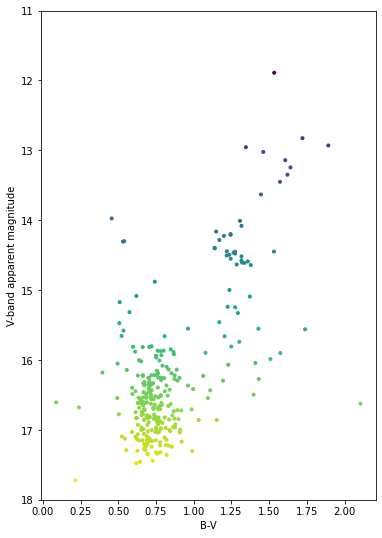

In [199]:
plt.figure(figsize=(6,9))
plt.scatter( stars_B['App mag']-stars_V['App mag'], stars_V['App mag'], marker='.', c=stars_V['App mag'] )

plt.ylim(18,11)

plt.xlabel('B-V')
plt.ylabel('V-band apparent magnitude')

Text(0, 0.5, 'B-band apparent magnitude')

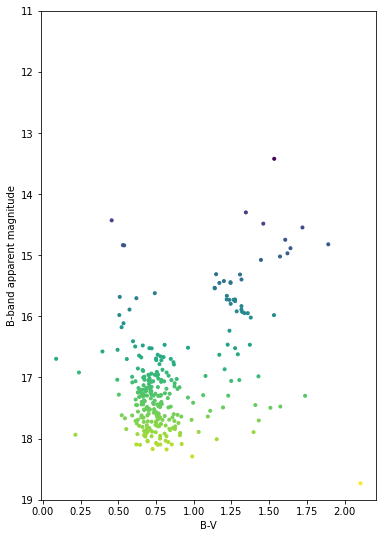

In [201]:
plt.figure(figsize=(6,9))
plt.scatter( stars_B['App mag']-stars_V['App mag'], stars_B['App mag'], marker='.', c=stars_B['App mag'] )

plt.ylim(19,11)

plt.xlabel('B-V')
plt.ylabel('B-band apparent magnitude')